# 8 性能评估

## 8.1 性能分析与基准测试

### Nsight System Profiler

* 使用 NVTX 范围（NVTX ranges）对代码进行标注，这些标注会在性能分析结果的“NVTX”行中以块的形式显示，包含所有相关的 CUDA API 调用及关联的内核执行。
* 通过以下方式标注自注意力层的不同部分，从而分离出模型正向传播和反向传播过程中对应的内核，甚至定位自注意力层各组件对应的内核

In [ ]:
import torch.cuda.nvtx as nvtx

@nvtx.range("缩放点积注意力")
def annotated_scaled_dot_product_attention(
    # Q、K、V、掩码等参数
):
    with nvtx.range("计算注意力分数"):
        1# 计算 Q 和 K 之间的注意力分数
    with nvtx.range("计算 softmax"):
        1# 计算注意力分数的 softmax
    with nvtx.range("最终矩阵乘法"):
        1# 计算输出投影
    return


我们执行


In [ ]:
nsys profile --stats=true -o test python .\training_loop.py



然后导入生成的文件到 NSYS gui分析

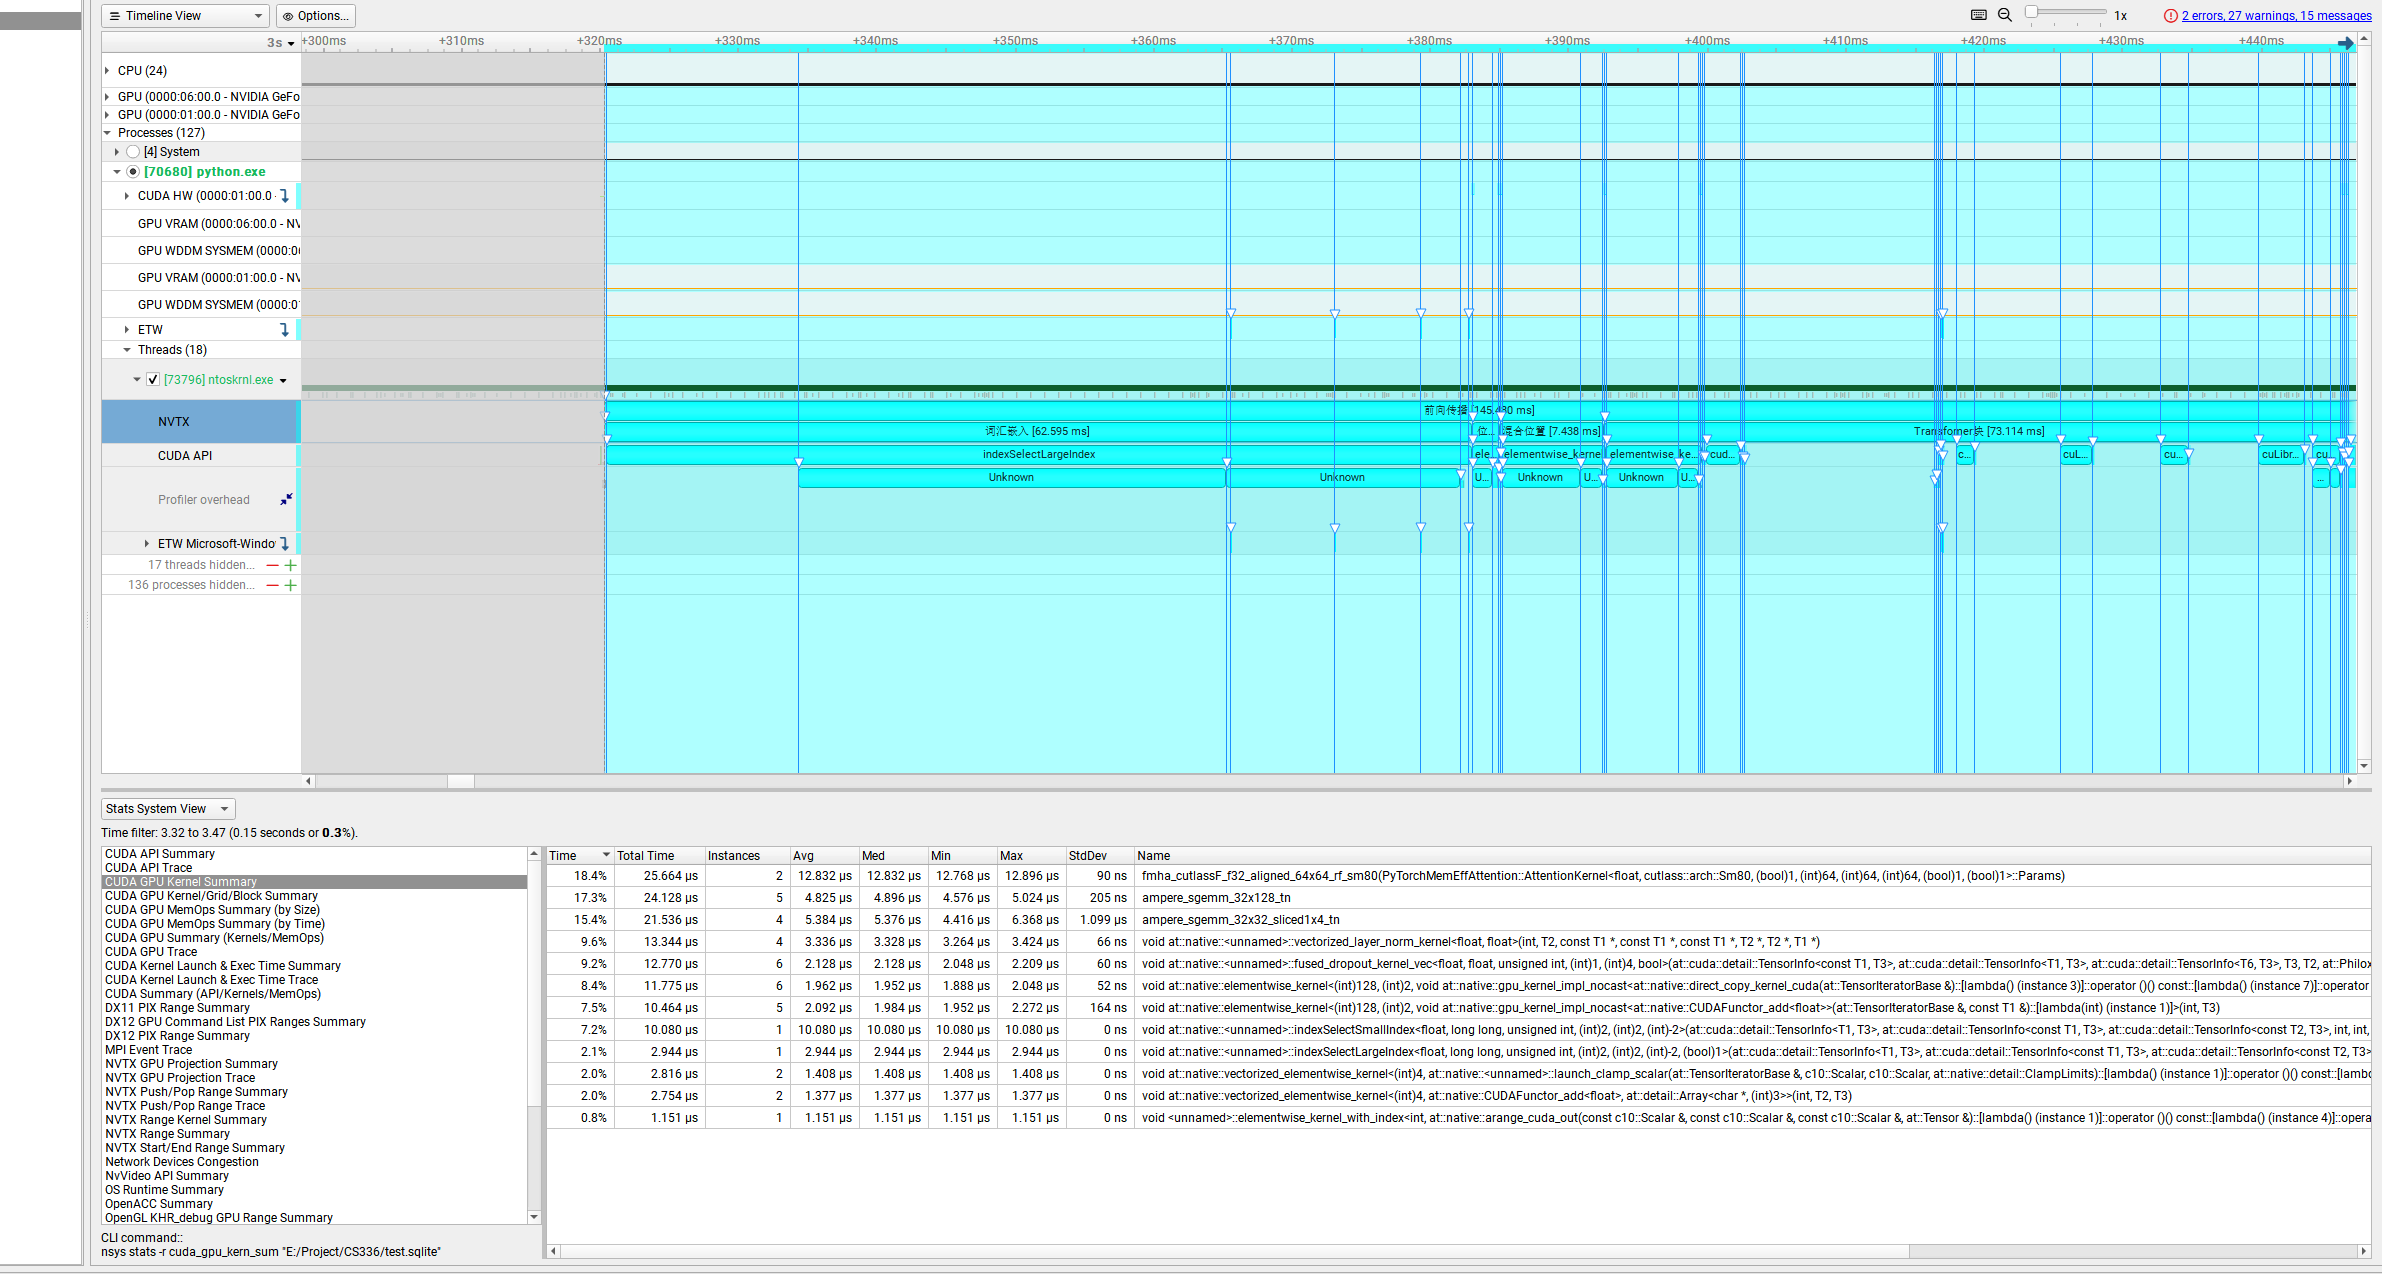

可以看到一个Transfomer块占用了很多的时间（我用的是pytorch的方法，暂时不知道怎么对库函数标注）

### 1.1.2 混合精度

我们看看在不同精度下积累的误差大小

In [1]:
import torch

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float32)
print(s) # tensor(10.0001)

s = torch.tensor(0, dtype=torch.float16)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float16)
print(s) # tensor(9.9531, dtype=torch.float16)

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    s += torch.tensor(0.01, dtype=torch.float16)
print(s) # tensor(10.0021)

s = torch.tensor(0, dtype=torch.float32)
for i in range(1000):
    x = torch.tensor(0.01, dtype=torch.float16)
    s += x.type(torch.float32)
print(s) # tensor(10.0021)

tensor(10.0001)
tensor(9.9531, dtype=torch.float16)
tensor(10.0021)
tensor(10.0021)


#### 问题（benchmarking_mixed_precision）：运行以下代码并评论结果（的准确性）。

假设我们在GPU上训练该模型，且模型参数初始为FP32精度。我们希望使用FP16的自动混合精度训练，请指出以下组件的数据类型：
* 自动混合精度上下文（autocast context）内的模型参数 **(FP32)**
* 第一个前馈层（ToyModel.fc1）的输出 **(FP16)**
* 层归一化（ToyModel.ln）的输出 **(FP32)**
* 模型的预测对数概率（logits） **(FP32)**
* 损失（loss） **(FP32)**
* 模型的梯度（gradients） **(FP32)**


In [2]:
from torch import nn

class ToyModel(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 10, bias=False)
        self.ln = nn.LayerNorm(10)
        self.fc2 = nn.Linear(10, out_features, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.ln(x)
        x = self.fc2(x)
        return x


### 1.1.3 内存分析


要使用内存分析器，可按以下方式修改基准测试脚本：



In [7]:
import torch

# 基准测试脚本中的预热阶段
...
# 开始记录内存历史
torch.cuda.memory._record_memory_history(max_entries=1000000)
# 你要分析的代码部分
...
# 保存Pickle文件，供PyTorch在线工具加载
torch.cuda.memory._dump_snapshot("memory_snapshot.pickle")
# 停止记录历史
torch.cuda.memory._record_memory_history(enabled=None)


运行后会生成 `memory_snapshot.pickle` 文件，可将其加载到以下[在线工具](https://pytorch.org/memory_viz)中。该工具将展示整体内存使用时间线，以及每个单独的内存分配（包括分配大小和指向代码来源的调用栈）。使用时，在浏览器中打开上述链接，将Pickle文件拖放到页面即可。

请使用PyTorch分析器分析模型的内存使用情况。


#### 问题（memory_profiling）：4分
分析表1中2.7B模型在上下文长度为128、256和512时的正向传播、反向传播和优化器步骤。

1.  在你的分析脚本中添加选项，使模型能够通过内存分析器运行。可复用之前的部分架构（如启用混合精度、加载特定模型规模等）。然后运行脚本，获取2.7B模型仅推理（仅正向传播）或完整训练步骤（正向传播、反向传播、优化器步骤）的内存分析结果。内存时间线呈现何种特征？能否根据观察到的峰值判断当前运行阶段？

**提交要求**：两张来自memory_viz工具的2.7B模型“活跃内存时间线”图片（一张为正向传播，一张为完整训练步骤），以及2-3句话的回复。


看一下[教程](https://zhuanlan.zhihu.com/p/677203832)
对`training_loop.py` 添加修改

In [8]:
%run "training_loop.py"

训练数据: 1000 tokens, 验证数据: 1000 tokens
模型参数数量: 32,420
开始训练...
迭代 0/500 | 损失: 4.7631 | 用时: 0.6s
迭代 10/500 | 损失: 4.5663 | 用时: 0.7s
迭代 20/500 | 损失: 4.3700 | 用时: 0.7s
迭代 30/500 | 损失: 4.2208 | 用时: 0.8s
迭代 40/500 | 损失: 4.0662 | 用时: 0.8s
迭代 50/500 | 损失: 4.0005 | 用时: 0.9s
迭代 60/500 | 损失: 3.3750 | 用时: 0.9s
迭代 70/500 | 损失: 3.6874 | 用时: 1.0s
迭代 80/500 | 损失: 3.3868 | 用时: 1.0s
迭代 90/500 | 损失: 2.9924 | 用时: 1.0s
迭代 100/500 | 损失: 2.8219 | 用时: 1.1s
迭代 110/500 | 损失: 2.6906 | 用时: 1.1s
迭代 120/500 | 损失: 1.9648 | 用时: 1.2s
迭代 130/500 | 损失: 1.8678 | 用时: 1.2s
迭代 140/500 | 损失: 0.9483 | 用时: 1.3s
迭代 150/500 | 损失: 0.9302 | 用时: 1.3s
迭代 160/500 | 损失: 0.6806 | 用时: 1.3s
迭代 170/500 | 损失: 0.5434 | 用时: 1.4s
迭代 180/500 | 损失: 0.6271 | 用时: 1.4s
迭代 190/500 | 损失: 0.6967 | 用时: 1.5s
迭代 200/500 | 损失: 0.5795 | 用时: 1.5s
迭代 210/500 | 损失: 0.5559 | 用时: 1.5s
迭代 220/500 | 损失: 0.4850 | 用时: 1.6s
迭代 230/500 | 损失: 0.3631 | 用时: 1.6s
迭代 240/500 | 损失: 0.5983 | 用时: 1.7s
迭代 250/500 | 损失: 0.4434 | 用时: 1.7s
迭代 260/500 | 损失: 0.3152 | 用时: 1.8s
迭代 270

以下两张图是预热过程和5次完整训练过程

e:\Anaconda\envs\pytorch\Lib\site-packages\torch\profiler\profiler.py:445: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


3642.061767578125


e:\Anaconda\envs\pytorch\Lib\site-packages\torch\profiler\profiler.py:445: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


3634.341796875
3565.88623046875
3564.19091796875
3563.3388671875
3562.58837890625


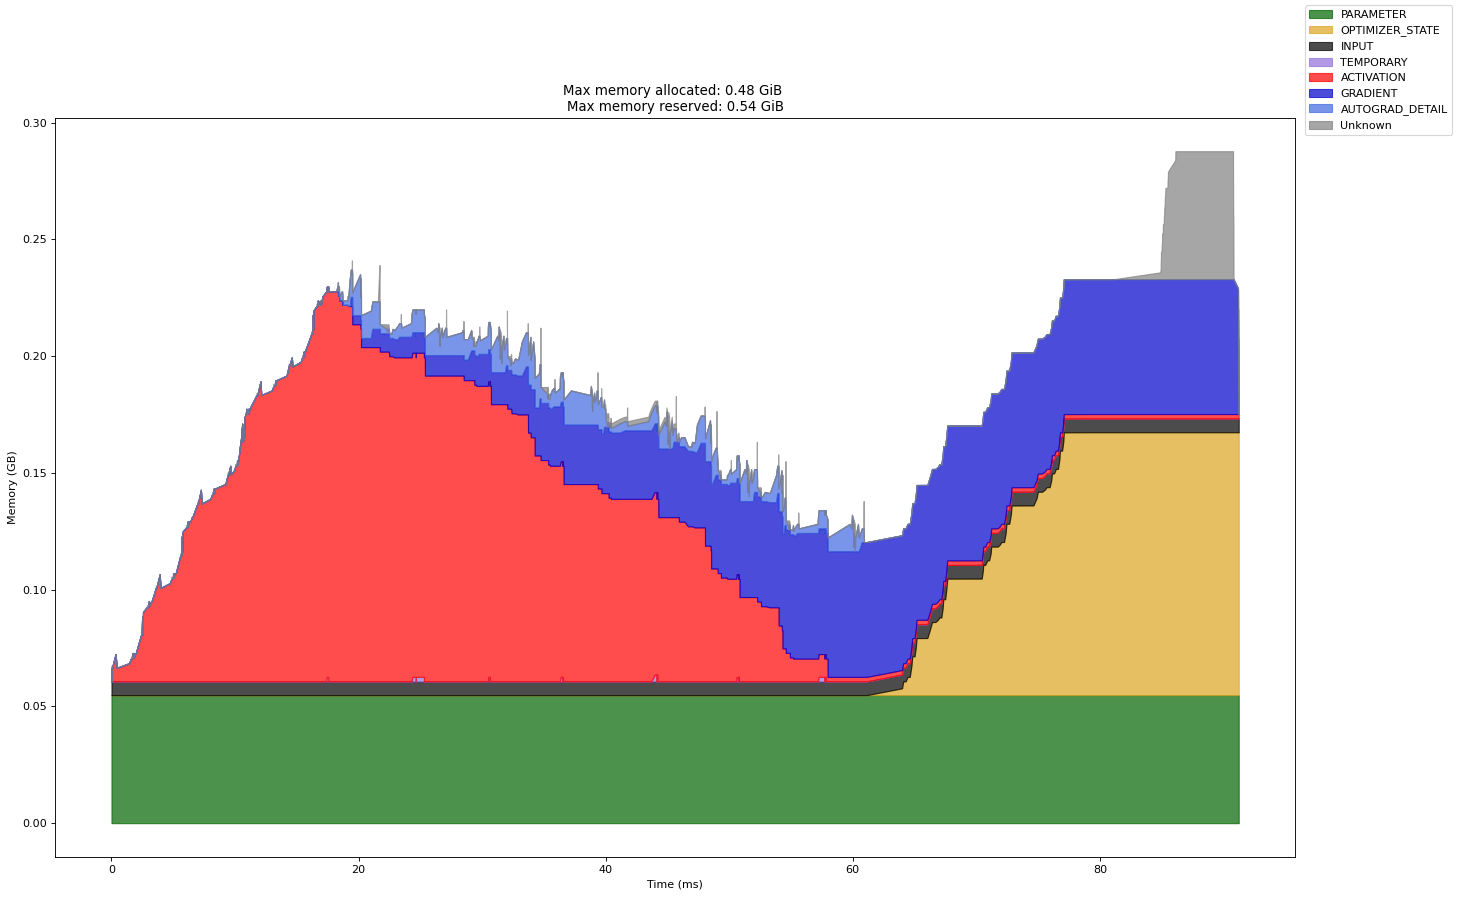

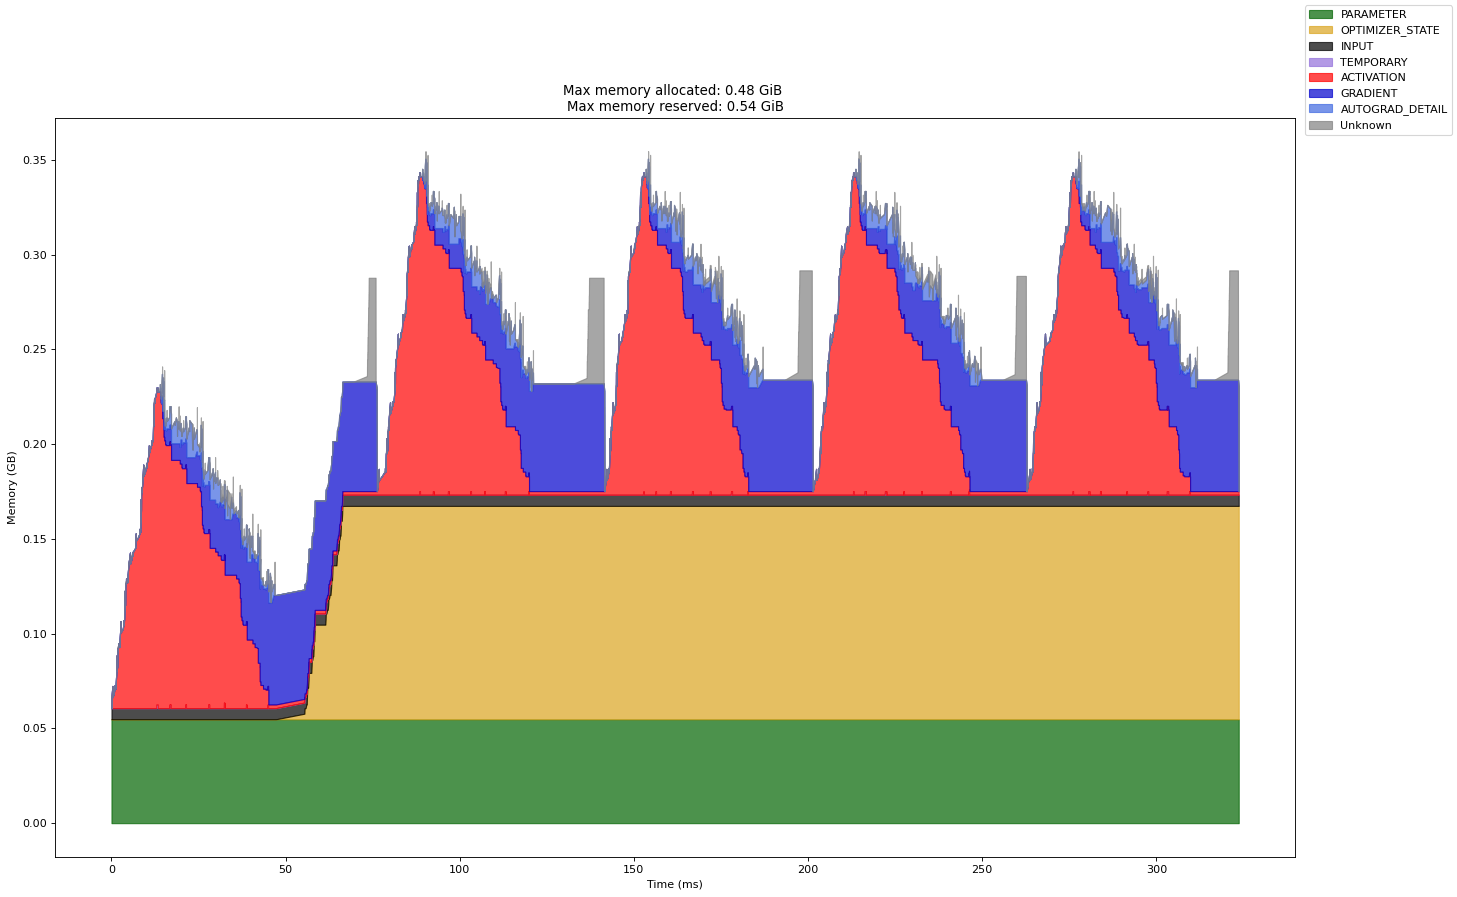

In [15]:
# Author: kevin.xie  zhihu@kaiyuan

import torch
from torch import nn
from datetime import datetime
from torch.autograd.profiler import record_function
import pickle


def trace_handler(prof: torch.profiler.profile):
   # 获取时间用于文件命名
   timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
   file_name = f"visual_mem_{timestamp}"

   # 导出tracing格式的profiling
   prof.export_chrome_trace(f"{file_name}.json")

   # 导出mem消耗可视化数据
   prof.export_memory_timeline(f"{file_name}.html", device="cuda:0")


def train(num_iter=5, device="cuda:0"):
    model = nn.Transformer(d_model=512, nhead=2, num_encoder_layers=2, num_decoder_layers=2,batch_first=True).to(device=device)
    x = torch.randn(size=(1, 1024, 512), device=device)
    tgt = torch.rand(size=(1, 1024, 512), device=device)
    model.train()
    labels = torch.rand_like(model(x, tgt))
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    with torch.profiler.profile(
            activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
            schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
            record_shapes=True,
            profile_memory=True,
            with_stack=True,
            on_trace_ready=trace_handler,
    ) as prof:
        for _ in range(num_iter):
            prof.step()
            with record_function("## forward ##"): 
                y = model(x, tgt)

            with record_function("## backward ##"):
                loss = criterion(y, labels)
                loss.backward()
                print(loss.item())

            with record_function("## optimizer ##"):
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)


if __name__ == "__main__":
    # warm-up:
    train(1)
    # run:
    train(5)


* parameter：模型参数
* optimizer_state: 优化器状态参数
* input：输入值
* temporary：临时变量；
* activation：激活值（前向运算产生）
* gradient：梯度值
* autograd_detail: 自动梯度产生的显存
* unknown：无法分类的消耗

**注意，进行warn-up动作是必要的，不然产生的数据会不符合预期。**



## 8.2 用FlashAttention-2优化注意力机制



### 8.2.1 PyTorch注意力机制基准测试
[Flash Attention 原理讲解](https://www.bilibili.com/video/BV17CPkeEEHH/?share_source=copy_web&vd_source=c379ccdab784832c917bb852fa2b0584)

注意力层在内存和计算方面存在优化空间。从高层来看，注意力操作包括三次矩阵乘法和一次softmax激活：

1. 计算查询（Q）、键（K）的点积以得到注意力分数；
2. 对注意力分数应用softmax归一化；
3. 将归一化后的分数与值（V）进行矩阵乘法，得到最终注意力输出。


$$\text{Attention}(Q,K,V)=\text{softmax}\left( \text{mask}\left( \frac{QK^T}{\sqrt{d_k}}\right) \right)V$$
其中，$Q \in \mathbb{R}^{n \times d_k},K \in \mathbb{R}^{m \times d_k},V \in \mathbb{R}^{m \times d_v}$

首先我们应该知道计算机系统的存储系统是分级的，从速度最快的Cache缓存到显存(HBM)再到内存，速度依次减慢，容量逐渐增大
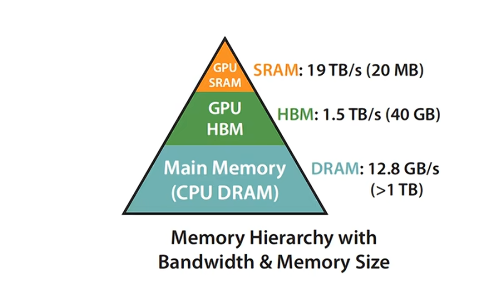



对于注意力机制，我们应该注意到 按位(ReLU ,mask)和规约(sum ,softmax)这一类**Memory Bound**操作占用了相当一部分时间开销，这就是 Flash Attention 要做的事情：优化 I/O 从而降低内存占用，提升效率。 

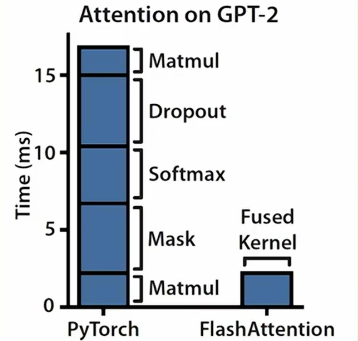



SRAM在核心内部，L1L2Cache通常是每个核心分配一点，Flash Attention 将QKV矩阵拆分成小段，得以在SRAM上并行计算

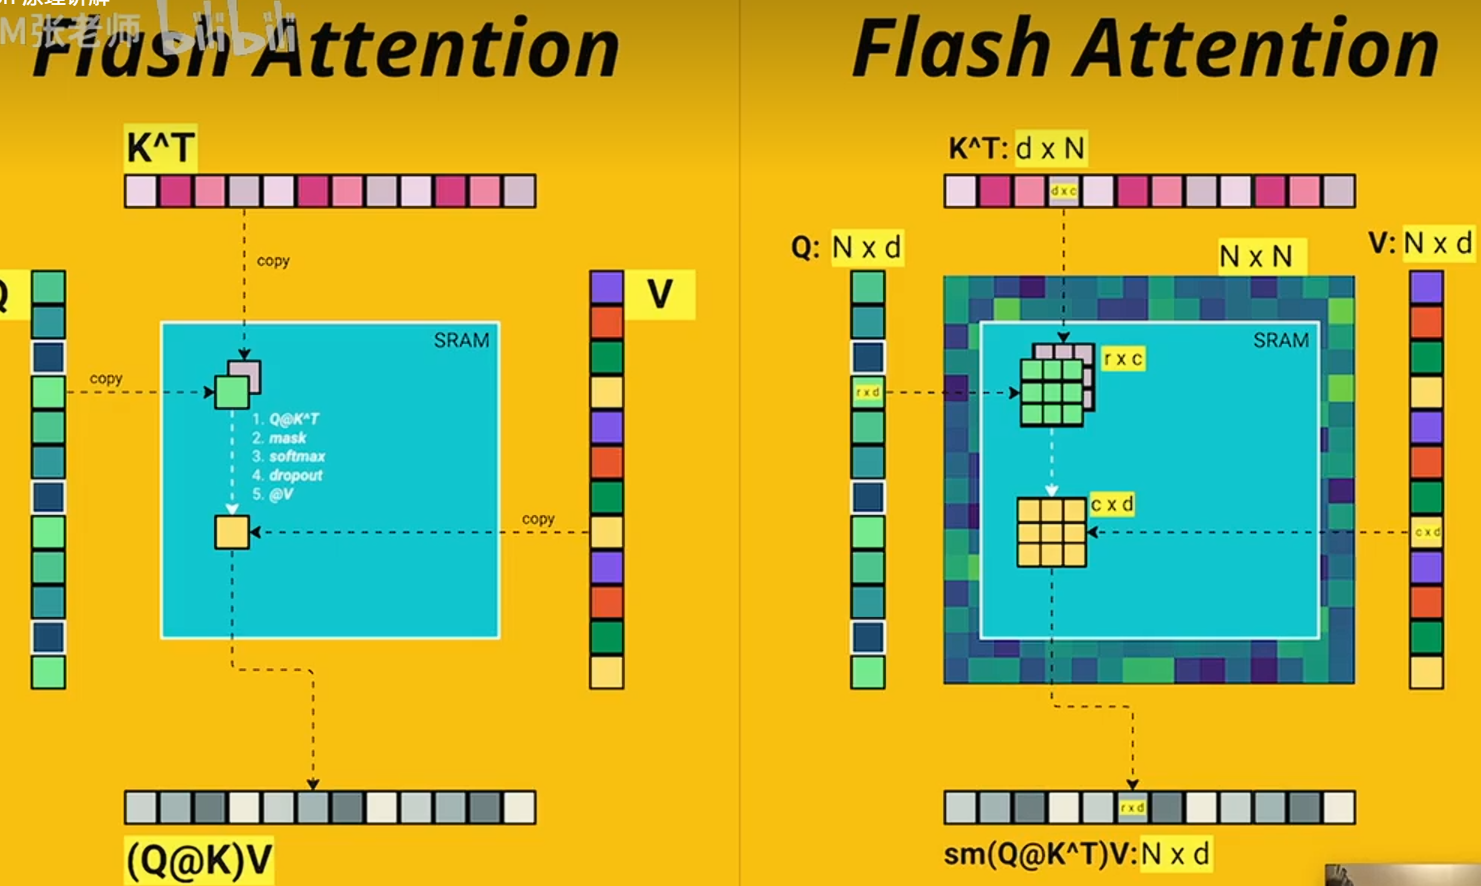